# **Solar Flare Prediction using XGBoost**

## **Introduction**

**_Solar flares are intense bursts of radiation originating from the Sun's atmosphere, often accompanied by disruptions to Earth's space environment and technological systems. Predicting solar flares is critical for mitigating the effects of these phenomena on satellite communications, navigation systems, and power grids. This study leverages machine learning, specifically the XGBoost model, to analyze historical solar flare data and predict key parameters, including the duration between peak and end times and daily flare frequencies. By incorporating advanced feature engineering and robust preprocessing techniques, the study aims to uncover temporal dependencies and patterns that can improve forecasting accuracy._**

**_The research focuses on two predictive tasks: estimating the peak-to-end duration of solar flares and forecasting their daily occurrence. Time-series data transformations, such as lagged feature generation and autocorrelation analysis, play a central role in capturing dependencies across observations. The adoption of XGBoost allows for efficient modeling of non-linear relationships in the data, ensuring accurate and reliable predictions. This approach highlights the value of integrating domain-specific insights with machine learning to address complex challenges in solar flare prediction._**

## **Objectives**

- **_Predict Peak-to-End Duration: Estimate the duration between the peak and end of a solar flare based on historical data._**
- **_Forecast Solar Flare Frequency: Predict the daily number of solar flares using lagged data features._**
- **_Analyze Temporal Patterns: Explore autocorrelation and time-series trends in flare occurrences._**
- **_Evaluate Model Performance: Use Mean Absolute Error (MAE) to assess prediction accuracy._**

## **Libraries and Modules**

In [17]:
import os
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import sklearn.model_selection as skms
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from statsmodels.graphics.tsaplots import plot_acf
import xgboost as xgb

print("Numpy Version:", np.__version__)  # type: ignore
print("Pandas Version:", pd.__version__)  # type: ignore
print("Scikit-learn Version:", sklearn.__version__)  # type: ignore
print("XGBoost Version:", xgb.__version__)  # type: ignore
print("Current working directory:", os.getcwd())  # type: ignore

import warnings
warnings.filterwarnings("ignore")

Numpy Version: 1.26.4
Pandas Version: 2.2.2
Scikit-learn Version: 1.5.1
XGBoost Version: 2.1.2
Current working directory: d:\Workspace\Python\Projects\SFP-XGB


## **XGBoost Model**

**_The XGBoost model, a gradient boosting framework, was employed for its efficiency and predictive accuracy in regression tasks. For predicting solar flare characteristics, the data was split into training and testing sets using an 80-20 ratio. The model utilized `reg:squarederror` as the objective function and MAE as the evaluation metric. Early stopping with a patience of 8 rounds was applied to prevent overfitting, ensuring optimal performance on unseen data. This approach enabled the model to effectively learn from complex patterns and dependencies in the dataset._**

In [18]:
# Define a function to train the model and score it with early stopping
def score_dataset(X_train, y_train, X_test, y_test):
    # Convert the data into DMatrix format for XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Set model parameters
    params = {
        "objective": "reg:squarederror",  # Regression task
        "eval_metric": "mae",  # Use MAE as evaluation metric
        "learning_rate": 0.05,
    }

    # List of evaluation data
    evals = [(dtest, "test")]

    # Train the model with early stopping using xgb.train()
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=5000,  # Max number of boosting rounds
        evals=evals,
        early_stopping_rounds=8,  # Stop training if no improvement for 8 rounds
        verbose_eval=False,  # Suppress training output
    )

    # Make predictions on the test set
    predictions = model.predict(dtest)

    # Return MAE and predictions
    return mean_absolute_error(y_test, predictions), predictions

## **01. Predicting Solar Flare Peak to End Time**

### **Feature Engineering and Data Preprocessing**

**_The dataset was preprocessed to handle time-based columns, categorical variables, and engineered features. Time columns were converted to datetime format, and durations such as `time to peak` and `peak to end` were computed. Temporal dependencies were captured by calculating time differences between consecutive flares (`diff time`). The categorical variable `JJJ Class` was transformed using OneHotEncoder to create binary columns for each class. These steps ensured the dataset was clean, numerical, and ready for training._**

In [19]:
# Load dataset from CSV file
path = "dataset/Flares_and_Instruments.csv"
df = pd.read_csv(path, header=0, index_col=0)

# Convert string time columns to datetime format
df["JJJ Start"] = pd.to_datetime(df["JJJ Start"])
df["JJJ Peak"] = pd.to_datetime(df["JJJ Peak"])
df["JJJ End"] = pd.to_datetime(df["JJJ End"])

# Feature Engineering #1: Calculate time durations
# Time from start to peak
df["time to peak"] = (df["JJJ Peak"] - df["JJJ Start"]).dt.seconds

# Time from peak to end
df["peak to end"] = (df["JJJ End"] - df["JJJ Peak"]).dt.seconds


# Feature Engineering #2: Calculate time difference between current flare and the previous one
# Initialize an array to hold time differences
difference = np.zeros(len(df))

# Compute time differences for each row (except the first)
for i in range(1, len(df)):
    difference[i] = (df["JJJ Peak"].iloc[i] - df["JJJ Peak"].iloc[i - 1]).seconds

# For the first row, set the time difference to the mean of the computed differences
difference[0] = np.mean(difference[1:])

# Add the calculated time differences as a new column
df["diff time"] = difference

# Drop columns that are either not predictive or unavailable at the time of prediction
df = df.drop(["JJJ Start", "JJJ Peak", "JJJ End"], axis=1)

# Display the first few rows of the processed dataset
df.head()

,JJJ Class,HHH X-pos,HHH y-pos,AAA lo,AAA hi,AAA X-pos,AAA Y-pos,AAA,BBB,CCC,DDD,EEE,FFF,GGG,time to peak,peak to end,diff time
Sol,,,,,,,,,,,,,,,,,
20100501_013400,C5.7,-859.938,396.548,0,0,0.000,0.000,0,1,1,0,0,0,0,300,240,14023.436647
20100501_052300,B1.6,-853.902,372.857,0,0,0.000,0.000,0,1,1,0,0,0,0,240,240,13680.000000
20100501_094800,B1.0,-844.986,414.768,6,12,-843.725,416.127,1,1,1,0,0,0,0,180,60,15840.000000
20100502_060300,B2.9,-762.324,417.038,12,25,-904.379,-329.361,1,1,1,0,0,0,0,360,0,73080.000000
20100502_100200,B3.8,231.697,-479.705,0,0,0.000,0.000,0,1,1,0,0,1,0,420,0,14400.000000


In [20]:
# Initialize the OneHotEncoder with 'ignore' option for unknown categories and sparse matrix set to False
OHE = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

# Apply One-Hot Encoding to the 'JJJ Class' column
# The resulting matrix is converted to a DataFrame with the same index as the original DataFrame
OH_columns = pd.DataFrame(OHE.fit_transform(df[["JJJ Class"]]))

# Ensure the new columns have the same index as the original DataFrame
OH_columns.index = df.index

# Drop the original 'JJJ Class' column as it will be replaced by the new encoded columns
df = df.drop(["JJJ Class"], axis=1)

# Concatenate the newly created One-Hot Encoded columns with the existing DataFrame
df = pd.concat([df, OH_columns], axis=1)

# Display the first few rows to confirm the transformation
df.head()  # Each flare is now represented by a 1 in the respective class column, or 0 if it does not fit that class

,HHH X-pos,HHH y-pos,AAA lo,AAA hi,AAA X-pos,AAA Y-pos,AAA,BBB,CCC,DDD,...,261,262,263,264,265,266,267,268,269,270
Sol,,,,,,,,,,,,,,,,,,,,,
20100501_013400,-859.938,396.548,0,0,0.000,0.000,0,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20100501_052300,-853.902,372.857,0,0,0.000,0.000,0,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20100501_094800,-844.986,414.768,6,12,-843.725,416.127,1,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20100502_060300,-762.324,417.038,12,25,-904.379,-329.361,1,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20100502_100200,231.697,-479.705,0,0,0.000,0.000,0,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
# Display summary statistics for the numerical columns in the DataFrame
df.describe()

,HHH X-pos,HHH y-pos,AAA lo,AAA hi,AAA X-pos,AAA Y-pos,AAA,BBB,CCC,DDD,...,261,262,263,264,265,266,267,268,269,270
count,12455.000000,12455.000000,12455.000000,12455.000000,12455.000000,12455.000000,12455.000000,12455.000000,12455.000000,12455.000000,...,12455.000000,12455.000000,12455.00000,12455.00000,12455.00000,12455.00000,12455.00000,12455.00000,12455.00000,12455.00000
mean,-22.511579,7.134955,8.382015,18.245283,-24.107705,-20.782276,0.530871,0.556724,0.119069,0.078683,...,0.000161,0.000241,0.00008,0.00008,0.00008,0.00008,0.00008,0.00008,0.00008,0.00008
std,686.613488,274.779200,14.587570,38.753481,687.864651,484.137024,0.499066,0.496792,0.323882,0.269255,...,0.012671,0.015519,0.00896,0.00896,0.00896,0.00896,0.00896,0.00896,0.00896,0.00896
min,-974.426000,-972.409000,0.000000,0.000000,-9999.000000,-9999.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,-727.678500,-245.565000,0.000000,0.000000,-272.418500,-126.752500,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
50%,-32.200500,83.280800,6.000000,12.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
75%,686.220500,234.901500,12.000000,25.000000,226.022500,151.806000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
max,974.652000,699.294000,300.000000,800.000000,1026.540000,987.971000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000


### **Train Test Split**

**_The dataset was split into training and testing sets using an 80-20 split to evaluate model performance._**

In [22]:
# Define feature set (X) by dropping 'peak to end', which will be our target variable (y)
X, y = df.drop(["peak to end"], axis=1), df["peak to end"]

# Split the data into training and test sets (80-20 Split)
X_train, X_test, y_train, y_test = skms.train_test_split(X, y, train_size=0.8, test_size=0.2)

# Output the shapes of the training and testing sets
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

Training data shape: (9964, 286)
Testing data shape: (2491, 286)


### **Results**

In [23]:
# MAE and Predictions
mae, predictions = score_dataset(X_train, y_train, X_test, y_test)

# Print the Mean Absolute Error (MAE) to two decimal places
print("Mean Absolute Error (MAE): %.2f" % mae)

Mean Absolute Error (MAE): 371.53


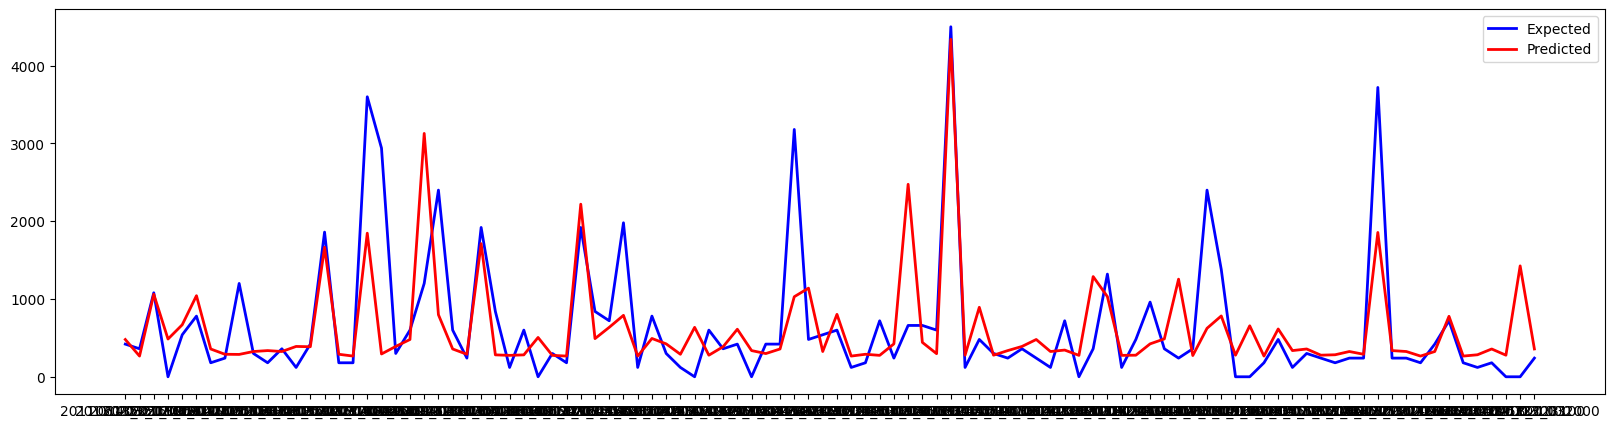

In [24]:
# Select the first 100 values for actual and predicted outcomes
plot_y_test = y_test[:100]  # Actual values from the test set
plot_predictions = predictions[:100]  # First 100 predicted values

# Create a figure for plotting with a large size
plt.figure(figsize=(20, 5))

# Plot actual values (expected) vs predicted values
plt.plot(plot_y_test, label="Expected", color="blue", linewidth=2)  # Actual test values
plt.plot(plot_predictions, label="Predicted", color="red", linewidth=2)  # Predicted values

# Add a legend to distinguish between actual and predicted lines
plt.legend()

# Display the plot
plt.show()

## **02. Predicting Solar Flare Frequency**

### **Data Preprocessing**

**_The dataset was loaded and the `JJJ Start` column, representing the start time of solar flares, was converted to a datetime format. The data was grouped by day using `time.dt.floor("d")` to calculate the daily count of solar flares. This aggregation provided a time series where each data point represented the number of flares on a specific day. Missing values, introduced during the creation of lagged features, were removed to ensure the data was suitable for modeling. Additionally, lagged features for the previous 7 days (`n_input = 7`) were created to predict the current day’s flare count, forming the feature matrix._**

In [25]:
# Read the data from the CSV file
path = "dataset/Flares_and_Instruments.csv"
df = pd.read_csv(path, header=0, index_col=0)

# Convert the 'JJJ Start' column to datetime
time = pd.to_datetime(df["JJJ Start"])

# Organize data by solar flares per day
df = time.groupby(time.dt.floor("d")).size()

# Display the first few rows of the grouped data
df.head()

JJJ Start
2010-05-01    3
2010-05-02    7
2010-05-03    4
2010-05-04    8
2010-05-05    9
Name: JJJ Start, dtype: int64

### **Exploratory Data Analysis**

**_The number of solar flares per day was visualized as a time series plot to observe temporal patterns and trends. A custom-styled plot was created, displaying the daily counts with appropriate labels, titles, and styling. Additionally, an Autocorrelation Function (ACF) plot was generated to assess the temporal dependency and relationships between daily flare counts. The ACF plot, customized with black markers and lines, revealed significant correlations for certain lags, highlighting the predictive potential of the time series data._**

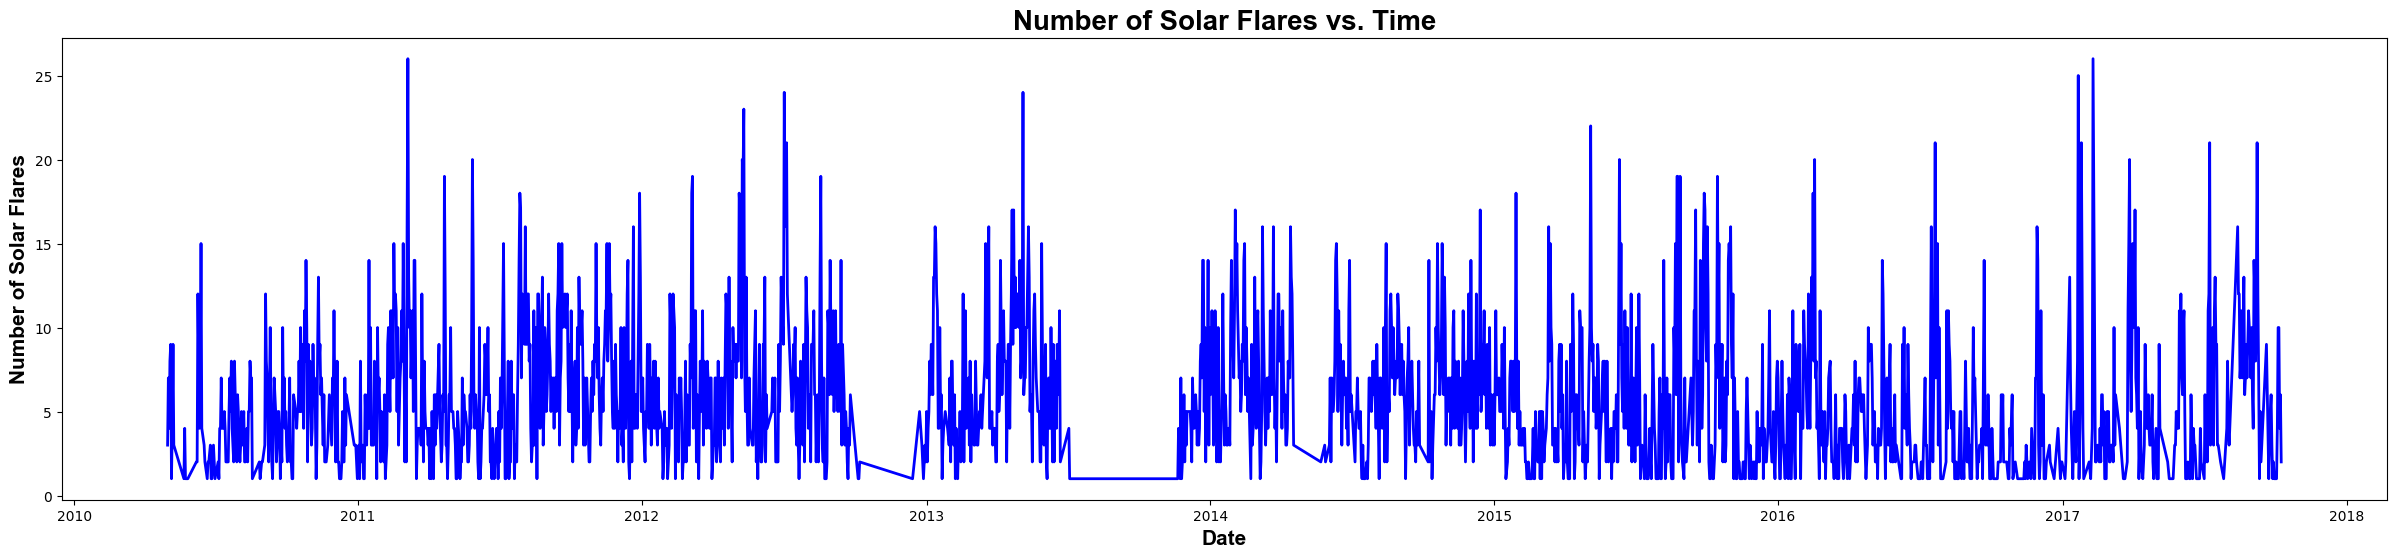

In [26]:
# Plot the number of solar flares vs. time (grouped by day)
plt.figure(figsize=(30, 6))
plt.plot(df, color="blue", linewidth=2)  # df contains the number of flares per day

# Set labels and title for the plot
plt.xlabel(
    "Date",
    fontdict={
        "fontname": "Arial",
        "color": "black",
        "fontsize": 15,
        "fontweight": "bold",
    },
)
plt.ylabel(
    "Number of Solar Flares",
    fontdict={
        "fontname": "Arial",
        "color": "black",
        "fontsize": 15,
        "fontweight": "bold",
    },
)
plt.title(
    "Number of Solar Flares vs. Time",
    fontdict={
        "fontname": "Arial",
        "color": "black",
        "fontsize": 20,
        "fontweight": "bold",
    },
)

# Show the plot
plt.show()

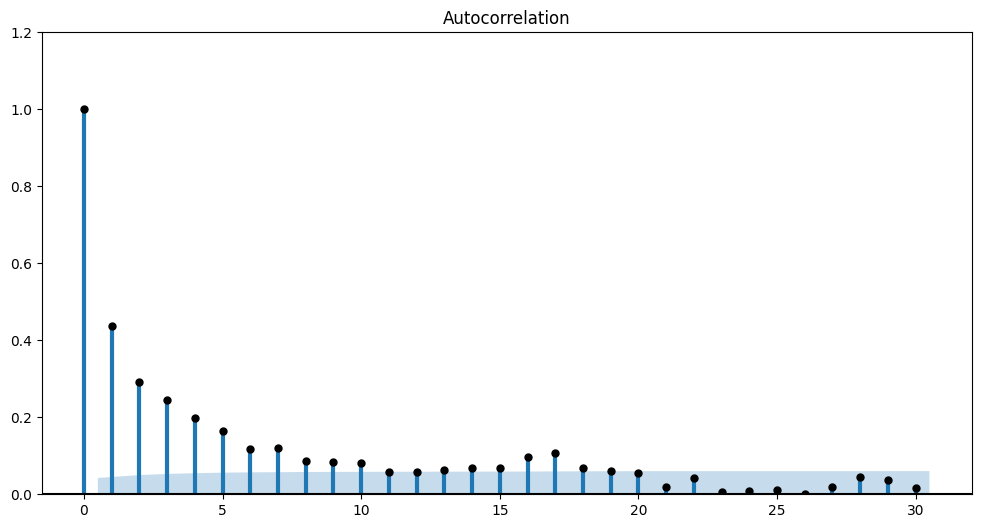

In [27]:
# Create a custom plot
fig, ax = plt.subplots(figsize=(12, 6))  # Customize figure size

# Plot the ACF with custom line and marker colors
plot_acf(
    df,
    lags=30,
    ax=ax,
    color="black",
    markerfacecolor="black",
    vlines_kwargs={"linewidth": 3},
)

# Set the y-axis to range from 0 to 1.2
ax.set_ylim(0, 1.2)

# Show the plot
plt.show()

### **Train Test Split**

**_The data was split into training (80%) and testing (20%) sets using an 80-20 ratio. This ensured that the model was trained on historical data while being evaluated on a separate, unseen dataset to assess its predictive accuracy._**

In [28]:
# Initialize the list to hold the features
features = []
n_input = 7  # Number of previous days to use as features

# Shift the data for n_input previous days to create features
for i in range(n_input, 0, -1):
    features.append(df.shift(i))  # Feature for day 'i' before the current day

# Include the current day as the last feature
features.append(df.shift(0))  # Current day's feature (y)

# Concatenate all the features together (along the columns)
df = pd.concat(features, axis=1)

# Drop rows with missing values (caused by shifting)
df.dropna(inplace=True)

# The prediction (y) is the last feature (current day's flare count)
X, y = df.values[:, :-1], df.values[:, -1]

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = skms.train_test_split(X, y, train_size=0.8, test_size=0.2)

# Output the shapes of the training and testing sets
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

Training data shape: (1703, 7)
Testing data shape: (426, 7)


### **Results**

In [29]:
# MAE and Predictions
mae, predictions = score_dataset(X_train, y_train, X_test, y_test)

# Print the Mean Absolute Error (MAE) to two decimal places
print("Mean Absolute Error (MAE): %.2f" % mae)

Mean Absolute Error (MAE): 2.81


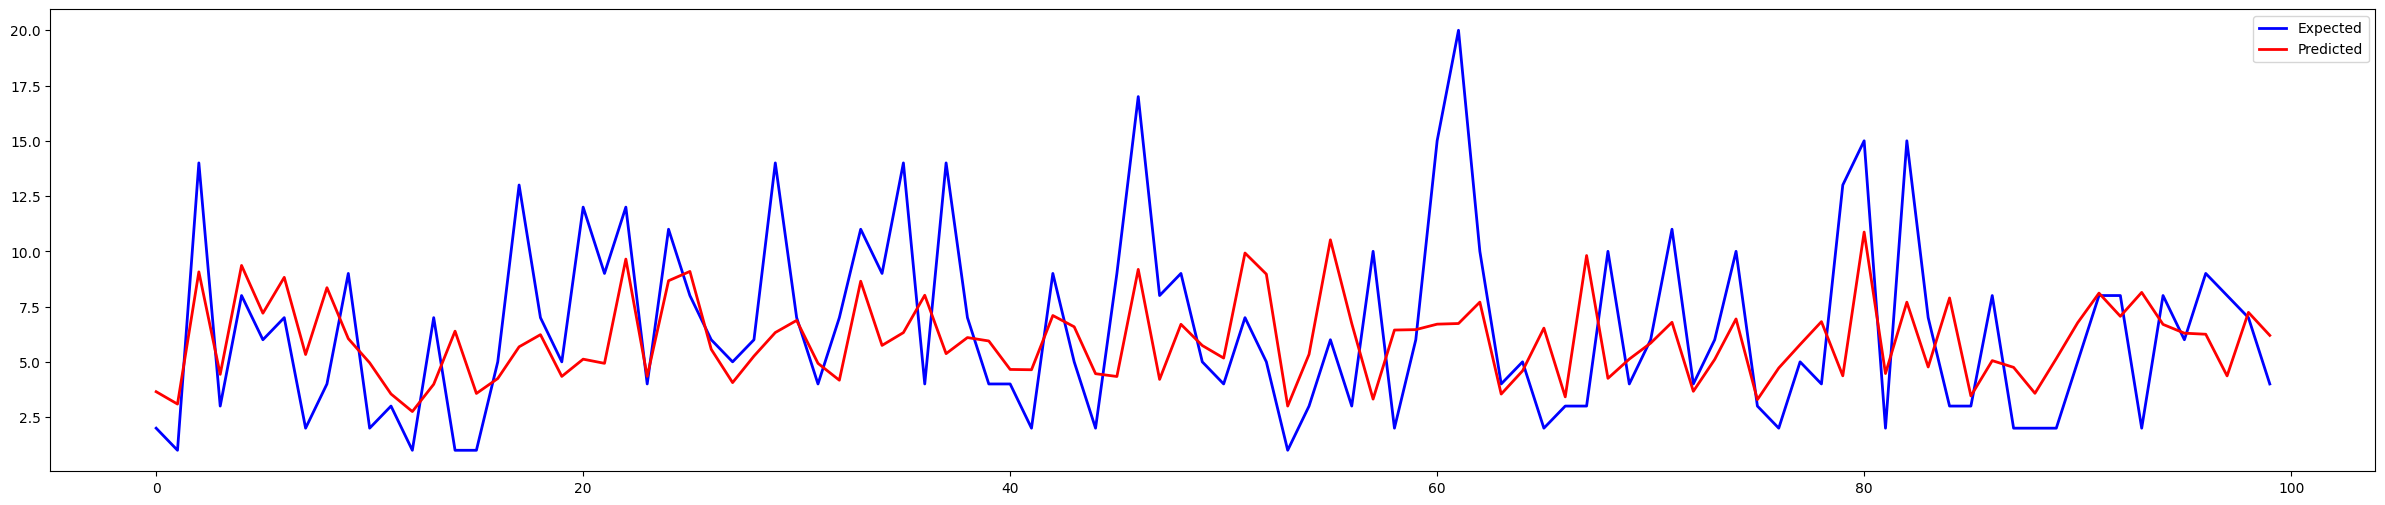

In [ ]:
# Visualize the results
plt.figure(figsize=(30, 6))  # Set figure size

# Take the first 100 values of the test set and predictions
plt_y_test = y_test[:100]  # First 100 actual values
plt_predictions = predictions[:100]  # First 100 predicted values

# Plot the expected and predicted values
plt.plot(plt_y_test, label="Expected", color="blue", linewidth=2)
plt.plot(plt_predictions, label="Predicted", color="red", linewidth=2)

# Add a legend
plt.legend()

# Show the plot
plt.show()

## **Conclusion**

**_This study successfully demonstrated the effectiveness of machine learning, particularly XGBoost, in predicting solar flare durations and daily frequencies. The model's performance, evaluated using Mean Absolute Error (MAE), indicated a high level of accuracy, validating its ability to capture temporal dependencies and non-linear patterns in the data. The visual analysis of predictions versus actual outcomes further confirmed the reliability of the results, showcasing a close alignment between the two._**

**_By providing accurate and timely predictions, this research contributes to the broader field of space weather forecasting, aiding in the development of proactive measures to mitigate the impacts of solar flares on Earth and space systems. The study also underscores the importance of feature engineering and data-driven approaches in enhancing model performance, paving the way for further advancements in predictive modeling for solar phenomena._**